In [6]:
import numpy as np
from numpy import arange
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from mlxtend.classifier import StackingClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = load_breast_cancer(as_frame=True)
data
# data.data -> dataframe of data
# data.target -> target col
# data.feature_names -> column names / features
# data.target_names -> target names malignant - 1 / benign - 0

{'data':      mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
 0          17.99         10.38          122.80     1001.0          0.11840   
 1          20.57         17.77          132.90     1326.0          0.08474   
 2          19.69         21.25          130.00     1203.0          0.10960   
 3          11.42         20.38           77.58      386.1          0.14250   
 4          20.29         14.34          135.10     1297.0          0.10030   
 ..           ...           ...             ...        ...              ...   
 564        21.56         22.39          142.00     1479.0          0.11100   
 565        20.13         28.25          131.20     1261.0          0.09780   
 566        16.60         28.08          108.30      858.1          0.08455   
 567        20.60         29.33          140.10     1265.0          0.11780   
 568         7.76         24.54           47.92      181.0          0.05263   
 
      mean compactness  mean concavity  me

In [3]:
data.target.value_counts()

1    357
0    212
Name: target, dtype: int64

Here we can notice that our dataset is somehow imblanced 

<AxesSubplot:>

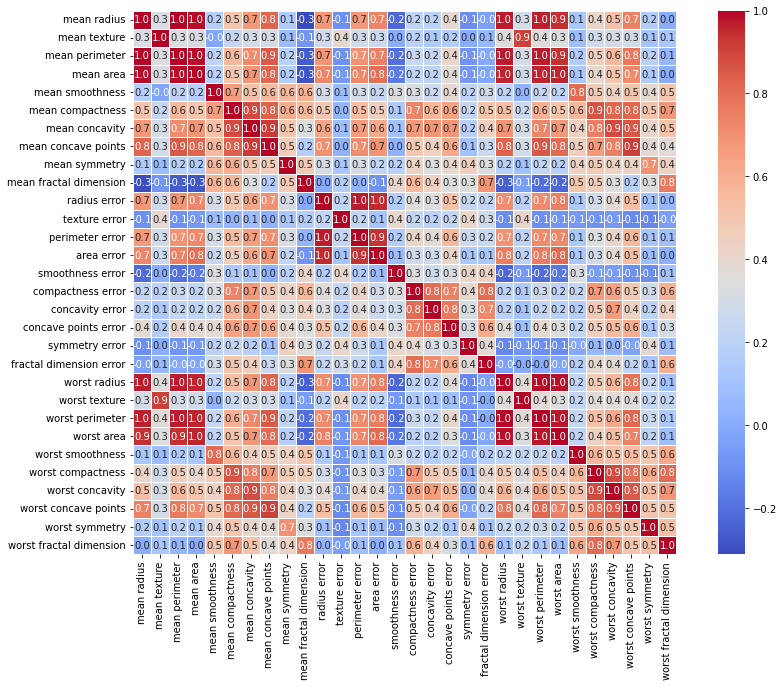

In [9]:
# depict correlation of features
corr = data.data.corr()

f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cbar = True,  square = True, annot = True, fmt= '.1f', xticklabels = True, yticklabels = True, cmap = "coolwarm", linewidths = .5, ax = ax)

In addition, we can notice some correlated columns in the dataset. In general, it is recommended to avoid having correlated features in the dataset, but because highly correlated features do not bring additional information, we will continue as it is. However, we could have removed the features with more than 80% correlation.

In [4]:
data.data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


We can also see that our data needs normalization as some columns have values around 0.1 and others have around 2000

In [91]:
# normalize our dataset
normalizer = StandardScaler()
data_norm = normalizer.fit_transform(data.data)
data_norm

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [92]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data_norm, data.target, test_size=0.3, random_state=42)

In [94]:
# configure the cross-validation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [135]:
# This function finds and returns the best params of RandomizedSearch based on mean_test_score
def find_best_params_rs(test_score, params, params_gs):
  # replace nan values with 0, so as to be able to take the max values
  np.nan_to_num(test_score, copy = False)

  # get the 10% of the best randomized Search params
  for _ in range(0, int(len(test_score)*0.1)):
    # get the index of the max score value
    max_index_col = np.argmax(test_score, axis=0)

    for param in params[max_index_col]:
      # check if the param already exists in the list
      if params[max_index_col][param] not in params_gs[param]:
        params_gs[param].append(params[max_index_col][param])

    # remove it from the array
    test_score = np.delete(test_score, max_index_col)
    params = np.delete(params, max_index_col)

  return params_gs

### Linear Discriminant Analysis

In [96]:
lda_clf = LinearDiscriminantAnalysis()

lda_params_rs = {
  'solver': ['svd', 'lsqr', 'eigen'],
  'shrinkage': arange(0, 1, 0.01),
  'tol': arange(0, 1, 0.01)
}

lda_rand_search = RandomizedSearchCV(lda_clf, lda_params_rs, scoring='f1', cv=cv, refit=True, n_iter=300)

# fit the model 
results_rs_lda = lda_rand_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
lda_best_model = results_rs_lda.best_estimator_

# evaluate model on the traindataset
yhat = lda_best_model.predict(X_test)
# evaluate the model
f1_score_lda = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_lda))
print('Mean f1 score: %.3f' % results_rs_lda.best_score_)
print('Config: %s' % results_rs_lda.best_params_)

F1 score is: 0.9727272727272727
Mean f1 score: 0.969
Config: {'tol': 0.63, 'solver': 'eigen', 'shrinkage': 0.15}


In [97]:
# find the best parameters from the randomized search
lda_params_gs = {
  'solver': [],
  'shrinkage': [],
  'tol': []
}

lda_params_gs = find_best_params_rs(results_rs_lda.cv_results_['mean_test_score'], results_rs_lda.cv_results_['params'], lda_params_gs)

In [98]:
lda_grid_search = GridSearchCV(lda_clf, lda_params_gs, scoring='f1', cv=cv, refit=True)

# fit the model 
results_gs_lda = lda_grid_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
lda_best_model = results_gs_lda.best_estimator_

# evaluate model on the traindataset
yhat = lda_best_model.predict(X_test)
# evaluate the model
f1_score_lda = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_lda))
print('Mean f1 score: %.3f' % results_gs_lda.best_score_)
print('Config: %s' % results_gs_lda.best_params_)

F1 score is: 0.9727272727272727
Mean f1 score: 0.969
Config: {'shrinkage': 0.1, 'solver': 'eigen', 'tol': 0.63}


### Logistic Regression

In [100]:
lr_clf = LogisticRegression()

lr_params_rs = {
  'penalty': ['l1', 'l2', 'elasticnet', 'none'],
  'max_iter' : range(100, 500, 50),
  'warm_start' : [True, False],
  'fit_intercept' : [True, False],
  'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
  'C' : arange(0, 1, 0.01),
}

lr_rand_search = RandomizedSearchCV(lr_clf, lr_params_rs, scoring='f1', cv=cv, refit=True, n_iter=300, n_jobs=5)

# fit the model 
results_rs_lr = lr_rand_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
lr_best_model = results_rs_lr.best_estimator_

# evaluate model on the traindataset
yhat = lr_best_model.predict(X_test)
# evaluate the model
f1_score_lr = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_lr))
print('Mean f1 score: %.3f' % results_rs_lr.best_score_)
print('Config: %s' % results_rs_lr.best_params_)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

F1 score is: 0.9907407407407407
Mean f1 score: 0.984
Config: {'warm_start': False, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'fit_intercept': False, 'C': 0.27}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_

In [101]:
# find the best parameters from the randomized search
lr_params_gs = {
  'warm_start': [],
  'solver': [],
  'penalty': [],
  'max_iter': [],
  'fit_intercept': [],
  'C': [],
}

lr_params_gs = find_best_params_rs(results_rs_lr.cv_results_['mean_test_score'], results_rs_lr.cv_results_['params'], lr_params_gs)

In [102]:
lr_grid_search = GridSearchCV(lr_clf, lr_params_gs, scoring='f1', cv=cv, refit=True)

# fit the model 
results_gs_lr = lr_grid_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
lr_best_model = results_gs_lr.best_estimator_

# evaluate model on the traindataset
yhat = lr_best_model.predict(X_test)
# evaluate the model
f1_score_lr = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_lr))
print('Mean f1 score: %.3f' % results_gs_lr.best_score_)
print('Config: %s' % results_gs_lr.best_params_)

F1 score is: 0.9953917050691244
Mean f1 score: 0.986
Config: {'C': 0.22, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': False}


### Support Vector Machines

In [103]:
svm_clf = SVC()

svm_params_rs = {
  'kernel': ['linear', 'poly', 'rbf'],
  'C': range(1, 10),
  'gamma': arange(0.01, 1, 0.1)
}

svm_rs_search = RandomizedSearchCV(svm_clf, svm_params_rs, scoring='f1', cv=cv, refit=True, n_iter=300, n_jobs=5)

# fit the model 
results_rs_svm = svm_rs_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
svm_best_model = results_rs_svm.best_estimator_

# evaluate model on the traindataset
yhat = svm_best_model.predict(X_test)
# evaluate the model
f1_score_svm = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_svm))
print('Mean f1 score: %.3f' % results_rs_svm.best_score_)
print('Config: %s' % results_rs_svm.best_params_)

F1 score is: 0.9908256880733944
Mean f1 score: 0.986
Config: {'kernel': 'rbf', 'gamma': 0.01, 'C': 7}


In [104]:
svm_params_gs = {
  'kernel': [],
  'C': [],
  'gamma': []
}

svm_params_gs = find_best_params_rs(results_rs_svm.cv_results_['mean_test_score'], results_rs_svm.cv_results_['params'], svm_params_gs)

In [105]:
svm_grid_search = GridSearchCV(svm_clf, svm_params_gs, scoring='f1', cv=cv, refit=True, n_jobs=5)

# fit the model 
results_gs_svm = svm_grid_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
svm_best_model = results_gs_svm.best_estimator_

# evaluate model on the traindataset
yhat = svm_best_model.predict(X_test)
# evaluate the model
f1_score_svm = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_svm))
print('Mean f1 score: %.3f' % results_gs_svm.best_score_)
print('Config: %s' % results_gs_svm.best_params_)

F1 score is: 0.9908256880733944
Mean f1 score: 0.980
Config: {'C': 7, 'gamma': 0.01, 'kernel': 'rbf'}


### Extremely Randomized Trees

In [113]:
etc_clf = ExtraTreesClassifier()

etc_params_rs = {
  "n_estimators": range(10, 2000, 200),
  "criterion": ['gini', 'entropy', 'log_loss'],
  "max_depth": range(1, 20),
  "max_features": range(1, 18),
  "min_samples_split": range(2, 15)
}

etc_rand_search = RandomizedSearchCV(etc_clf, etc_params_rs, scoring='f1', cv=cv, refit=True, n_iter=300, n_jobs=5)

# fit the model 
results_rs_etc = etc_rand_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
etc_best_model = results_rs_etc.best_estimator_

# evaluate model on the traindataset
yhat = etc_best_model.predict(X_test)
# evaluate the model
f1_score_etc = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_etc))
print('Mean f1 score: %.3f' % results_rs_etc.best_score_)
print('Config: %s' % results_rs_etc.best_params_)

F1 score is: 0.981651376146789
Mean f1 score: 0.978
Config: {'n_estimators': 1610, 'min_samples_split': 3, 'max_features': 16, 'max_depth': 14, 'criterion': 'log_loss'}


In [122]:
# find the best parameters from the randomized search
etc_params_gs = {
  'n_estimators': [],
  'criterion': [],
  'max_depth': [],
  'max_features': [],
  'min_samples_split': []
}

etc_params_gs = find_best_params_rs(results_rs_etc.cv_results_['mean_test_score'], results_rs_etc.cv_results_['params'], etc_params_gs)

In [125]:
etc_grid_search = GridSearchCV(etc_clf, etc_params_gs, scoring='f1', cv=cv, refit=True, n_jobs=6)

# fit the model 
results_gs_etc = etc_grid_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
etc_best_model = results_gs_etc.best_estimator_

# evaluate model on the traindataset
yhat = etc_best_model.predict(X_test)
# evaluate the model
f1_score_etc = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_etc))
print('Mean f1 score: %.3f' % results_gs_etc.best_score_)
print('Config: %s' % results_gs_etc.best_params_)

F1 score is: 0.981651376146789
Mean f1 score: 0.978
Config: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 16, 'min_samples_split': 5, 'n_estimators': 210}


### XGBoost

In [127]:
xgb_clf = XGBClassifier(objective="binary:logistic")

xgb_params_rs = {
  'learning_rate' : arange(0.01, 0.5, 0.05),
  'max_depth' : range(1, 20),
  'min_child_weight' : range(1, 10, 2),
  'gamma': arange(0.1, 0.5, 0.05),
  'colsample_bytree' : arange(0.1, 1, 0.1),
  "n_estimators": range(10, 2000, 100),
}

xgb_rand_search = RandomizedSearchCV(xgb_clf, xgb_params_rs, scoring='f1', cv=cv, refit=True, n_iter=300, n_jobs=5)

# fit the model 
results_rs_xgb = xgb_rand_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
xgb_best_model = results_rs_xgb.best_estimator_

# evaluate model on the traindataset
yhat = xgb_best_model.predict(X_test)
# evaluate the model
f1_score_xgb = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_xgb))
print('Mean f1 score: %.3f' % results_rs_xgb.best_score_)
print('Config: %s' % results_rs_xgb.best_params_)

F1 score is: 0.9724770642201834
Mean f1 score: 0.976
Config: {'n_estimators': 710, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.20000000000000004, 'colsample_bytree': 0.7000000000000001}


In [136]:
# find the best parameters from the randomized search
xgb_params_gs = {
  'learning_rate': [],
  'max_depth': [],
  'min_child_weight': [],
  'gamma': [],
  'colsample_bytree': [],
  'n_estimators': []
}

xgb_params_gs = find_best_params_rs(results_rs_xgb.cv_results_['mean_test_score'], results_rs_xgb.cv_results_['params'], xgb_params_gs)

In [138]:
xgb_grid_search = GridSearchCV(xgb_clf, xgb_params_gs, scoring='f1', cv=cv, refit=True, n_jobs=7)

# fit the model 
results_gs_xgb = xgb_grid_search.fit(X_train, y_train)
# get the best performing model fit on the whole training set
xgb_best_model = results_gs_xgb.best_estimator_

# evaluate model on the traindataset
yhat = xgb_best_model.predict(X_test)
# evaluate the model
f1_score_xgb = f1_score(y_test, yhat)

print("F1 score is: " + str(f1_score_xgb))
print('Mean f1 score: %.3f' % results_gs_xgb.best_score_)
print('Config: %s' % results_gs_xgb.best_params_)

F1 score is: 0.9724770642201834
Mean f1 score: 0.981
Config: {'colsample_bytree': 0.30000000000000004, 'gamma': 0.1, 'learning_rate': 0.21000000000000002, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 710}


### Final best models

In [143]:
final_lda_clf = LinearDiscriminantAnalysis(shrinkage=0.1, solver='eigen', tol=0.63).fit(X_train, y_train)
y_pred_lda = final_lda_clf.predict(X_test)

final_lr_clf = LogisticRegression(penalty='l2', max_iter=100, warm_start=False, fit_intercept=True, solver='liblinear', C=0.22).fit(X_train, y_train)
y_pred_lr = final_lr_clf.predict(X_test)

final_svm_clf = SVC(kernel='rbf', C=7, gamma=0.01, probability=True).fit(X_train, y_train)
y_pred_svm = final_svm_clf.predict(X_test)

final_etc_clf = ExtraTreesClassifier(n_estimators=210, criterion='entropy', max_depth=10, max_features=16, min_samples_split=5).fit(X_train, y_train)
y_pred_etc = final_etc_clf.predict(X_test)

final_xgb_clf = XGBClassifier(learning_rate=0.21, max_depth=3, min_child_weight=1, gamma=0.1, colsample_bytree=0.3, n_estimators=710).fit(X_train, y_train)
y_pred_xgb = final_xgb_clf.predict(X_test)


**Because our dataset is imbalanced, is better to use the balanced_accuracy as metric, instead of accuracy_score**

In [151]:
# Results of Final Models

print("-----Linear Discriminant Analysis------")
print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_lda))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_lda))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, final_lda_clf.predict_proba(X_test)[:, 1]))
print()

print("-----Logistic Regression------")
print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_lr))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_lr))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, final_lr_clf.predict_proba(X_test)[:, 1]))
print()

print("-----Support Vector Machine------")
print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_svm))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_svm))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, final_svm_clf.predict_proba(X_test)[:, 1]))
print()

print("-----Extremely RandomizedTtrees------")
print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_etc))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_etc))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, final_etc_clf.predict_proba(X_test)[:, 1]))
print()

print("-----XGBoost Classifier------")
print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_xgb))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_xgb))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, final_xgb_clf.predict_proba(X_test)[:, 1]))
print()

-----Linear Discriminant Analysis------
Balanced Accuracy score: 0.956
F1 score is: 0.973
ROC AUC is: 0.997

-----Logistic Regression------
Balanced Accuracy score: 0.992
F1 score is: 0.995
ROC AUC is: 0.998

-----Support Vector Machine------
Balanced Accuracy score: 0.984
F1 score is: 0.991
ROC AUC is: 0.997

-----Extremely RandomizedTtrees------
Balanced Accuracy score: 0.972
F1 score is: 0.982
ROC AUC is: 0.999

-----XGBoost Classifier------
Balanced Accuracy score: 0.959
F1 score is: 0.972
ROC AUC is: 0.994



#### Voting Classifier

In [149]:
voting_clf = VotingClassifier(estimators=[('lda', final_lda_clf), ('lr', final_lr_clf), ('svm', final_svm_clf), 
                                            ('etc', final_etc_clf), ('xgb', final_xgb_clf)], voting='soft')
voting_clf = voting_clf.fit(X_train, y_train)

y_pred_voting_clf = voting_clf.predict(X_test)

print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_voting_clf))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_voting_clf))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1]))

Balanced Accuracy score: 0.979
F1 score is: 0.986
ROC AUC is: 0.998


#### Stacking Classifier

In [150]:
stacking_clf = StackingClassifier(classifiers=[final_lda_clf, final_lr_clf, final_svm_clf, final_etc_clf, final_xgb_clf], 
                          meta_classifier=LogisticRegression())

stacking_clf.fit(X_train, y_train)

y_pred_stacking_clf = stacking_clf.predict(X_test)

print("Balanced Accuracy score: %.3f" % balanced_accuracy_score(y_test, y_pred_stacking_clf))
print("F1 score is: %.3f" % f1_score(y_test, y_pred_stacking_clf))
print("ROC AUC is: %.3f" % roc_auc_score(y_test, stacking_clf.predict_proba(X_test)[:, 1]))

Balanced Accuracy score: 0.972
F1 score is: 0.982
ROC AUC is: 0.991


### Deductions
<hr />
<table>
<tr>
<th></th>
<th>Linear Discriminant Analysis</th>
<th>Logistic Rgression</th>
<th>Support Vector Machine</th>
<th>Extremely RandomizedTtrees</th>
<th>XGBClassifier</th>
<th>Voting</th>
<th>Stacking</th>
</tr>
<tr>
<td>Balanced Accuracy</td>
<td>0.956</td>
<td>0.992</td>
<td>0.984</td>
<td>0.972</td>
<td>0.959</td>
<td>0.979</td>
<td>0.972</td>
</tr>

<tr>
<td>F1 score</td>
<td>0.973</td>
<td>0.995</td>
<td>0.991</td>
<td>0.982</td>
<td>0.972</td>
<td>0.986</td>
<td>0.982</td>
</tr>

<tr>
<td>ROC AUC</td>
<td>0.997</td>
<td>0.998</td>
<td>0.997</td>
<td>0.999</td>
<td>0.994</td>
<td>0.998</td>
<td>0.991</td>
</tr>
</table>

Observing the results above, we can conclude that the **Logistic Regression** performs almost perfect to the dataset, achieving 99% to all the metrics. However, all the methods managed to achieve a good performance with average of 97% in the metrics.

* Note: high performance does not always mean a good/accurate model, as there are possibilities of overfitting.